## Task 1

Каждая строчка датасета - пост из твиттера, два класса: катастрофа и нет

1. Необходимо очистить данные от лишних символов и стоп-слов
2. Построить информативные графики, демонстрирующие специфику датасета
3. Применить 3 способа токенизации (по словам, bpe, berttokenizer)
4. Сделать одну векторизацию и 2 варианта эмбеддингов. Один из алгоритмов эмбеддингов предобученная модель (huggingface).
5. Визуализировать близость получившихся эмбеддингов, цветами окрасить разные классы. Можно применить PCA перед отрисовкой
6. Для каждой используемой технологии в комментариях около ячейки с кодом написать своими словами принцип (идею) алгоритма. Описания похожие на текст от GPT приниматься не будут.
7. Выложить на github


## Imports

In [ ]:
# !pip install transformers
# !pip install torch

In [97]:
import pandas as pd
import html
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from transformers import BertTokenizer, BertModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## 1. Очистите данные от лишних символов и стоп-слов

In [147]:
df = pd.read_csv('socialmedia_relevant_cols.csv', encoding='latin1')
df = df.drop_duplicates()

In [149]:
df.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


Мы видим, что в текстах содержатся числа и ссылки, хештеги, неанглийские символы, ники, другие небуквенные и нечисленные символы, которые  имеет смысл удалить (хештеги сохраняю, чтобы далее использовать эту информацию) 

Также провожу лемматизацию с учетом части речи слова (поскольку nltk в спорных случаях по умолчанию считает каждое слово существительным)

In [151]:
for row in df['text'][:10]:
    print(row)

Just happened a terrible car crash
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Heard about #earthquake is different cities, stay safe everyone.
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Apocalypse lighting. #Spokane #wildfires


In [153]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z#]', ' ', text).lower()

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    pos_tags = nltk.pos_tag(filtered_text)

    lemmatizer = WordNetLemmatizer()
    
    lemmatized_text = list()

    for token, tag in pos_tags:
        pos = get_wordnet_pos(tag)
        if pos:
            lemma = lemmatizer.lemmatize(token, pos=pos)
        else:
            lemma = lemmatizer.lemmatize(token)
        lemmatized_text.append(lemma)
    
    return ' '.join(lemmatized_text)

In [155]:
df['Cleaned_Text'] = df['text'].apply(clean_text)

In [156]:
for row in df['Cleaned_Text'][:10]:
    print(row)

happen terrible car crash
deed reason # earthquake may allah forgive u
heard # earthquake different city stay safe everyone
forest fire spot pond geese flee across street save
forest fire near la ronge sask canada
resident ask shelter place notify officer evacuation shelter place order expect
people receive # wildfire evacuation order california
get sent photo ruby # alaska smoke # wildfire pour school
# rockyfire update california hwy close direction due lake county fire # cafire # wildfire
apocalypse light # spokane # wildfire


## 2. Постройте информативные графики, демонстрирующие специфику датасета

**2.1 WordCloud со всеми словами датасета**

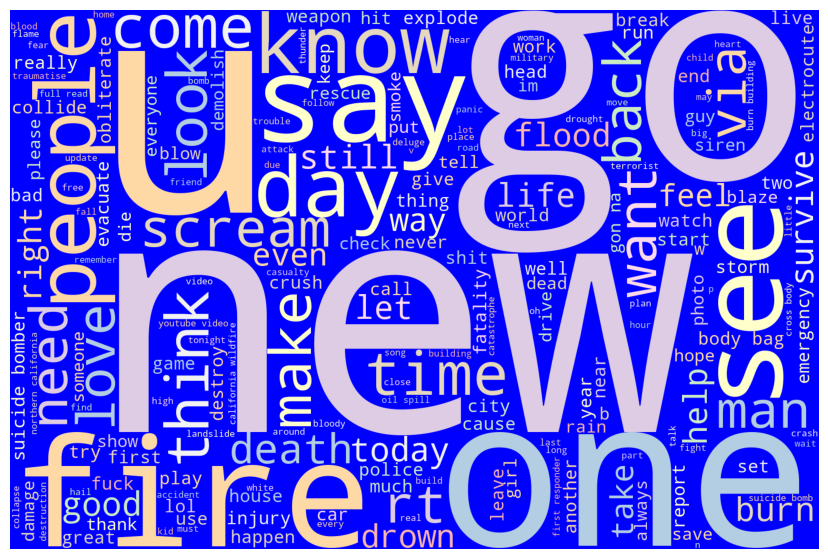

In [159]:
text = df['Cleaned_Text']

wordcloud = WordCloud(width = 1500,
                      height = 1000,
                      background_color='blue',
                      colormap='Pastel1').generate(', '.join(text))
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**2.2 WordCloud только с #**

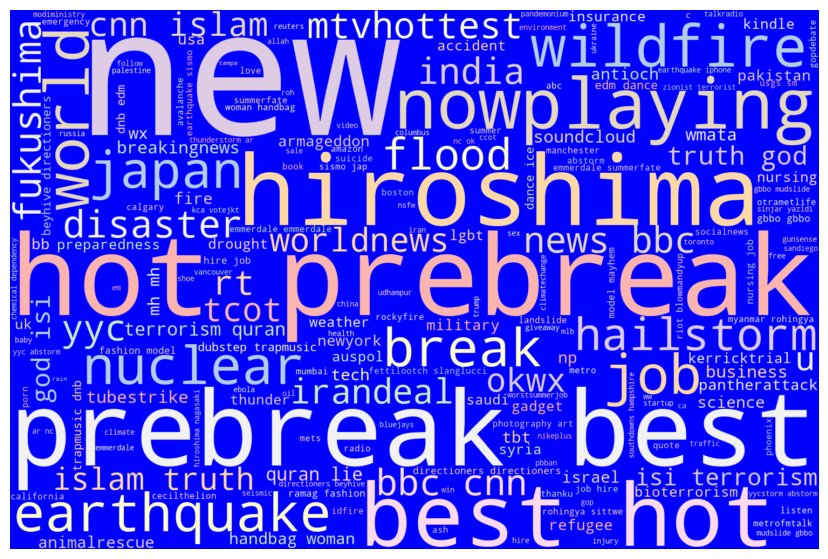

In [161]:
def extract_hashtags(text):
    hashtags = re.findall(r'#\s\w+', text)
    return ' '.join(hashtags)

df['Hashtags'] = df['Cleaned_Text'].apply(extract_hashtags)

wordcloud = WordCloud(width=1500,
                      height=1000,
                      background_color='blue',
                      colormap='Pastel1').generate(' '.join(df['Hashtags']))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**2.3 Самые частотные биграмы**

In [163]:
def extract_bigrams(text):
    tokens = nltk.word_tokenize(text)
    bigrams = list(nltk.bigrams(tokens))
    return bigrams

df['Bigrams'] = df['Cleaned_Text'].apply(extract_bigrams)
flattened = [bigram for i in df['Bigrams'] for bigram in i]
bigrams = Counter(flattened)
print(bigrams.most_common(5))

[(('body', 'bag'), 103), (('#', 'news'), 102), (('suicide', 'bomber'), 84), (('look', 'like'), 74), (('gon', 'na'), 66)]


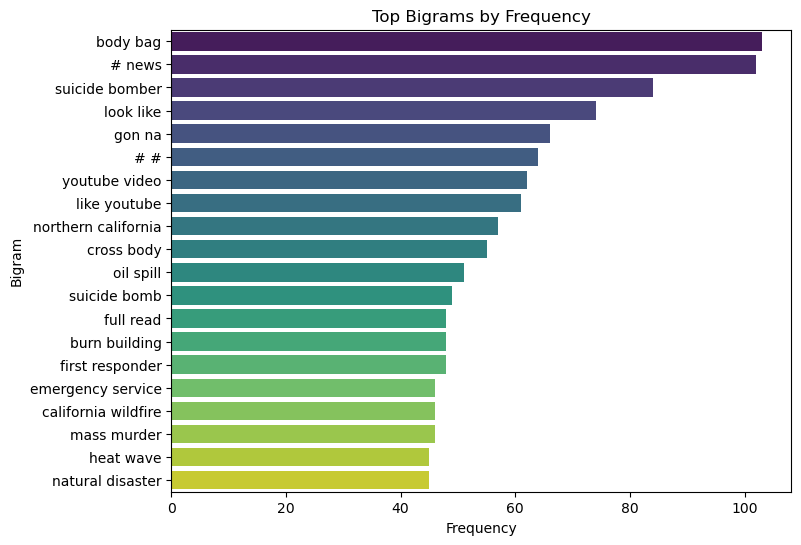

In [165]:
sorted_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
df_b = pd.DataFrame(sorted_bigrams, columns=['Bigram', 'Frequency'])
df_b['Bigram'] = df_b['Bigram'].apply(lambda x: ' '.join(x))

top_bigrams = df_b.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Top Bigrams by Frequency')
plt.show()

**2.4 Соотношение твитов про катастрофы и нет**

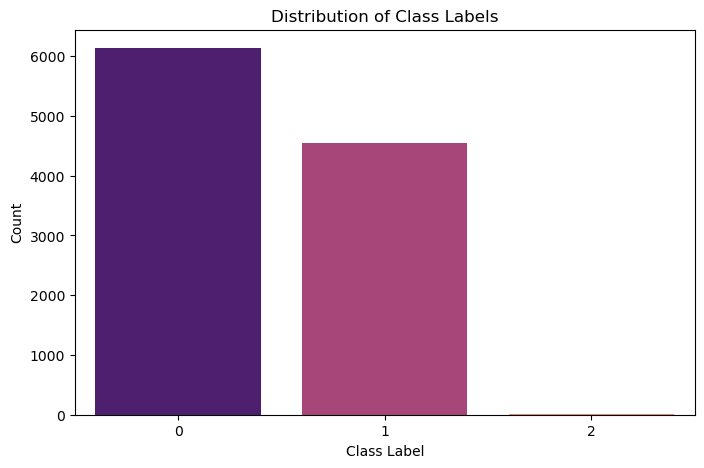

In [167]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='class_label', palette='magma')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

Здесь видно, что классов на самом деле 3 - незначительная доля твитов причислена к 'промежуточному классу' - можем избавиться от них

In [169]:
df = df[df['class_label'] != 2]
df.head()

,text,choose_one,class_label,Cleaned_Text,Hashtags,Bigrams
0,Just happened a terrible car crash,Relevant,1,happen terrible car crash,,"[(happen, terrible), (terrible, car), (car, cr..."
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,deed reason # earthquake may allah forgive u,# earthquake,"[(deed, reason), (reason, #), (#, earthquake),..."
2,"Heard about #earthquake is different cities, s...",Relevant,1,heard # earthquake different city stay safe ev...,# earthquake,"[(heard, #), (#, earthquake), (earthquake, dif..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,forest fire spot pond geese flee across street...,,"[(forest, fire), (fire, spot), (spot, pond), (..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,forest fire near la ronge sask canada,,"[(forest, fire), (fire, near), (near, la), (la..."


In [188]:
df['Words'] = df['Cleaned_Text'].apply(lambda row: row.split())

**2.5 Частота слов и хештегов в классах**

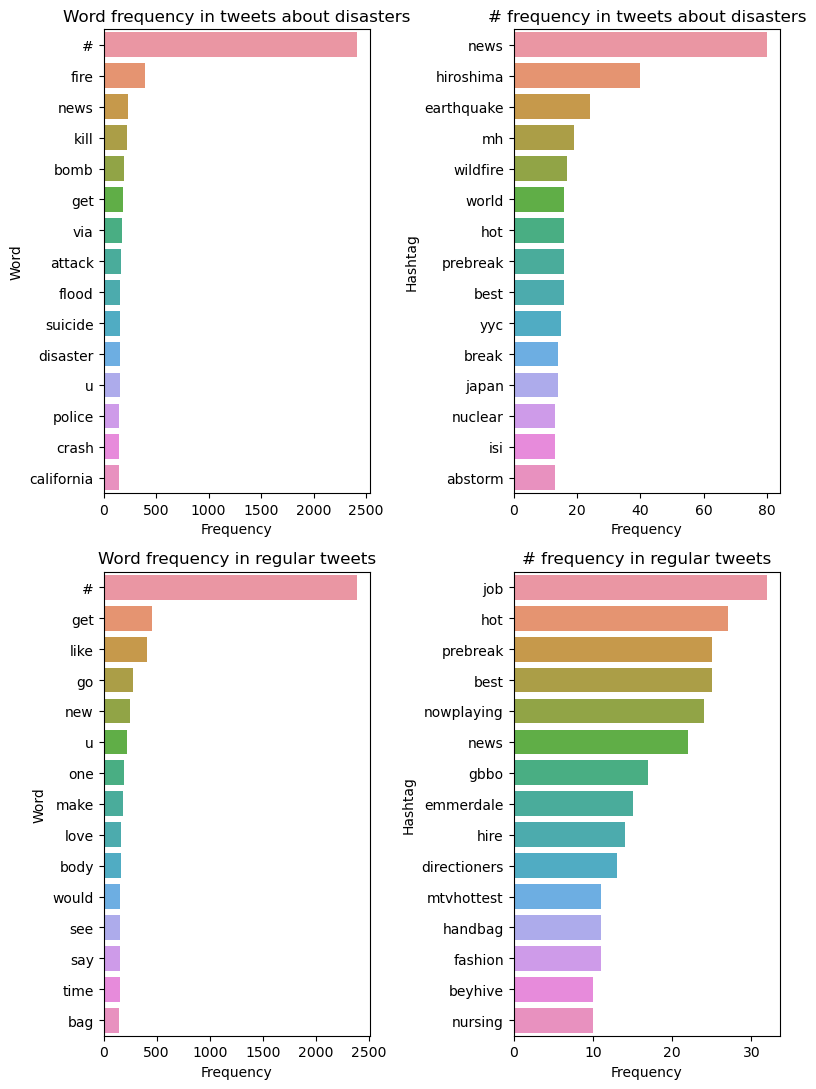

In [220]:
def get_top_words(corpus, n=None):
    counter = Counter(corpus)
    return counter.most_common(n)

fig, axes = plt.subplots(2, 2, figsize=(8, 11))

for i, label in enumerate(df['class_label'].unique()):
    class_df = df[df['class_label'] == label]

    all_words = [word for words in class_df['Words'] for word in words]
    top_words = get_top_words(all_words, 15)
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

    all_hashtags = [hashtag for hashtags in class_df['Hashtags'] for hashtag in hashtags.split() if hashtag != '#']
    top_hashtags = get_top_words(all_hashtags, 15)

    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    top_hashtags_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Frequency'])

    class_titles_words = {
    0: 'Word frequency in regular tweets',
    1: 'Word frequency in tweets about disasters'
    }
    
    class_titles_hashtags = {
    0: '# frequency in regular tweets',
    1: '# frequency in tweets about disasters'
    }

    sns.barplot(x='Frequency', y='Word', data=top_words_df, ax=axes[i, 0])
    axes[i, 0].set_title(class_titles_words[label])

    sns.barplot(x='Frequency', y='Hashtag', data=top_hashtags_df, ax=axes[i, 1])
    axes[i, 1].set_title(class_titles_hashtags[label])

plt.tight_layout()
plt.show()

## 3. Примените три способа токенизации

**3.1. 'По словам'**

Я уже выполняла эту токенизацию на этапе предобработки текста

принцип работы:


nltk способен разбивать тексты по разным принципам, в данном случае, он делит тексты по словам. отдельные слова определяются с помощью пробелов, знаков препинания, а также некоторых установленных правил (например, nltk может различать аббревиатуры)

**3.2. BPE**

принцип работы:

BPE - более сложная модель. она разбивает текст на слова, а слова - на отдельные буквы - и затем считает, какие комбинации букв встречаются чаще всего, чтобы объединить их. путем многократного повторения находится нужное кол-во новых символов, которые теперь воспринимаются как единое целое. в итоге текст кодируется эффективнее


In [223]:
with open('cleaned_tweets.txt', 'w', encoding='utf-8') as f:
    for text in df['Cleaned_Text']:
        f.write(f'{text}\n')

In [225]:
BPE_tokenizer = Tokenizer(models.BPE())

trainer = trainers.BpeTrainer(vocab_size=15000, min_frequency=5, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

BPE_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
BPE_tokenizer.train(files=['cleaned_tweets.txt'], trainer=trainer)

def tokenize_BPE(text):
    tokens = BPE_tokenizer.encode(text)
    return tokens.tokens, tokens.ids
    
df[['BPE_tokens', 'BPE_ids']] = df['Cleaned_Text'].apply(lambda x: pd.Series(tokenize_BPE(x)))

**3.3. BERT**

принцип работы:

это еще более мощная модель, основанная на архитектуре трансформеров и обучающаяся на большом объеме текстов. в отличие от других моделей, она читает тексты и слева-направо, и справа-налево, что способствует лучшему контекстуальному пониманию слов.  как и в предыдущем алгоритме, текст разбивается на отдельные слова и затем символы; часто встречающиеся пары символов комбинируются, чтобы создать подслова.

In [227]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_BERT(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=80, return_tensors="pt")

def ids_attention_masks_and_tokens(text):
    tokens = tokenize_BERT(text)
    ids = tokens['input_ids'].squeeze().tolist()
    token_strs = tokenizer.convert_ids_to_tokens(ids)
    return ids, token_strs

df[['BERT_ids', 'BERT_tokens']] = df['Cleaned_Text'].apply(lambda x: pd.Series(ids_attention_masks_and_tokens(x)))


In [228]:
df.head()

,text,choose_one,class_label,Cleaned_Text,Hashtags,Bigrams,Words,BPE_tokens,BPE_ids,BERT_ids,BERT_tokens
0,Just happened a terrible car crash,Relevant,1,happen terrible car crash,,"[(happen, terrible), (terrible, car), (car, cr...","[happen, terrible, car, crash]","[happen, terrible, car, crash]","[760, 3053, 279, 304]","[101, 4148, 6659, 2482, 5823, 102, 0, 0, 0, 0,...","[[CLS], happen, terrible, car, crash, [SEP], [..."
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,deed reason # earthquake may allah forgive u,# earthquake,"[(deed, reason), (reason, #), (#, earthquake),...","[deed, reason, #, earthquake, may, allah, forg...","[de, ed, reason, #, earthquake, may, allah, fo...","[45, 132, 1342, 5, 924, 342, 3542, 4484, 26]","[101, 15046, 3114, 1001, 8372, 2089, 16455, 96...","[[CLS], deed, reason, #, earthquake, may, alla..."
2,"Heard about #earthquake is different cities, s...",Relevant,1,heard # earthquake different city stay safe ev...,# earthquake,"[(heard, #), (#, earthquake), (earthquake, dif...","[heard, #, earthquake, different, city, stay, ...","[heard, #, earthquake, different, city, stay, ...","[1396, 5, 924, 2461, 599, 1293, 982, 900]","[101, 2657, 1001, 8372, 2367, 2103, 2994, 3647...","[[CLS], heard, #, earthquake, different, city,..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,forest fire spot pond geese flee across street...,,"[(forest, fire), (fire, spot), (spot, pond), (...","[forest, fire, spot, pond, geese, flee, across...","[forest, fire, spot, pond, ge, ese, flee, acro...","[614, 118, 1592, 3736, 58, 2564, 4597, 1899, 1...","[101, 3224, 2543, 3962, 8644, 28519, 10574, 24...","[[CLS], forest, fire, spot, pond, geese, flee,..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,forest fire near la ronge sask canada,,"[(forest, fire), (fire, near), (near, la), (la...","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ron, ge, s, ask, canada]","[614, 118, 467, 73, 1077, 58, 24, 931, 2373]","[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...","[[CLS], forest, fire, near, la, ron, ##ge, sas..."


## 4. Сделайте одну векторизацию и 2 варианта эмбеддингов (один - предобученная модель (huggingface))

**4.1. TF-IDF**

принцип работы:

этот метод позволяет оценить, насколько важно слово, содержащее в конкретном тексте, относительно всех текстов. он преобразует текстовые данные в числовые признаки, которые может распознать модель. tf = сколько раз слово встречается в документе / кол-во слов в этом документе (какие слова важны в этом документе?), idf =  кол-во всех документов / кол-во документов, где встречается это слово (как часто/редко слово встречается во всех документах?). затем tf и idf перемножаются. таким образом, мы находим слова, которые типичны для этого документа, но нетипичны для других

In [231]:
tf_idf = TfidfVectorizer(max_features=5000)
matrix = tf_idf.fit_transform(df['Cleaned_Text'])

tf_df = pd.DataFrame(matrix.toarray(), columns=tf_idf.get_feature_names_out())

In [233]:
tf_df

,aa,aba,abandon,abbott,abbswinston,abc,abcnews,abe,ability,ablaze,...,zak,zayn,zaynmalik,zero,zionism,zionist,zipper,zombie,zone,zouma
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10686,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10688,0.0,0.0,0.0,0.0,0.0,0.406035,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
tfidf_mean = tf_df.mean(axis=0)

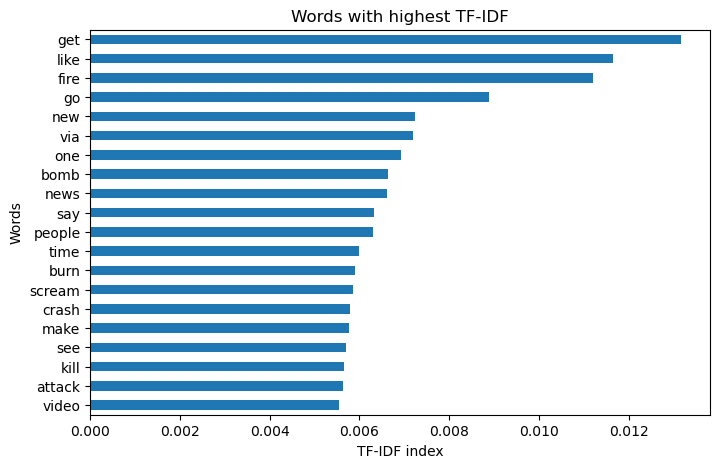

In [267]:
tfidf_mean = tf_df.mean(axis=0)
top_words = tfidf_mean.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 5))
top_words.plot(kind='barh')
plt.xlabel('TF-IDF index')
plt.ylabel('Words')
plt.title('Words with highest TF-IDF')
plt.gca().invert_yaxis()
plt.show()

**4.2. Word2Vec**

принцип работы:

в отличие от TF-IDF, о котором я писала выше, этот метод учитывает контекст, поскольку обучается на больших объемах текстов. векторы слов, которые создает этот метод, учитывает их смысл и взаимосвязь с другими словами через окружение. если слова часто встречаются рядом в тексте, их векторы будут ближе друг к другу

In [269]:
list_ = df['Cleaned_Text'].apply(lambda x: x.split()).tolist()
w2v_model = Word2Vec(list_, vector_size=50, min_count=10)

In [271]:
w2v_model.wv.most_similar("fire")

[('building', 0.9927880167961121),
 ('burn', 0.9919857382774353),
 ('forest', 0.9908050298690796),
 ('alarm', 0.990691065788269),
 ('crew', 0.9897710084915161),
 ('catch', 0.9895750880241394),
 ('annihilation', 0.9890841841697693),
 ('evacuate', 0.9889198541641235),
 ('late', 0.9887982606887817),
 ('abc', 0.9881082773208618)]

In [273]:
w2v_model.wv.most_similar("disaster")

[('saipan', 0.9946773052215576),
 ('obama', 0.9926083087921143),
 ('declare', 0.9924067854881287),
 ('devastate', 0.9921362400054932),
 ('declaration', 0.9885625839233398),
 ('typhoon', 0.988218367099762),
 ('sign', 0.9855841994285583),
 ('marians', 0.9786016941070557),
 ('natural', 0.9723150134086609),
 ('soudelor', 0.9709184765815735)]

In [275]:
w2v_model.wv.most_similar("hiroshima")

[('atomic', 0.9961386919021606),
 ('anniversary', 0.9912137389183044),
 ('bombing', 0.9902128577232361),
 ('mark', 0.9895095825195312),
 ('japan', 0.9894554615020752),
 ('th', 0.9889346361160278),
 ('nagasaki', 0.9875497221946716),
 ('year', 0.986110270023346),
 ('struggle', 0.9818246364593506),
 ('nuclear', 0.9805878400802612)]

**4.3. Hugging Face** - https://huggingface.co/fse/word2vec-google-news-300


In [277]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

def word2vec(text, model):
    embeddings = []
    words = []
    for word in text.split():
        if word in model:
            embeddings.append(model[word])
            words.append(word)
    if embeddings:
        return np.mean(embeddings, axis=0), words
    else:
        return np.zeros(model.vector_size), []

df['Word2Vec'] = df['Cleaned_Text'].apply(lambda x: word2vec(x, model))
df['Word2Vec_Embeddings'] = df['Word2Vec'].apply(lambda x: x[0])
df['Word2Vec_Words'] = df['Word2Vec'].apply(lambda x: x[1])

In [278]:
df.head()

,text,choose_one,class_label,Cleaned_Text,Hashtags,Bigrams,Words,BPE_tokens,BPE_ids,BERT_ids,BERT_tokens,Word2Vec,Word2Vec_Embeddings,Word2Vec_Words
0,Just happened a terrible car crash,Relevant,1,happen terrible car crash,,"[(happen, terrible), (terrible, car), (car, cr...","[happen, terrible, car, crash]","[happen, terrible, car, crash]","[760, 3053, 279, 304]","[101, 4148, 6659, 2482, 5823, 102, 0, 0, 0, 0,...","[[CLS], happen, terrible, car, crash, [SEP], [...","([0.079956055, 0.015838623, 0.03137207, -0.015...","[0.079956055, 0.015838623, 0.03137207, -0.0151...","[happen, terrible, car, crash]"
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1,deed reason # earthquake may allah forgive u,# earthquake,"[(deed, reason), (reason, #), (#, earthquake),...","[deed, reason, #, earthquake, may, allah, forg...","[de, ed, reason, #, earthquake, may, allah, fo...","[45, 132, 1342, 5, 924, 342, 3542, 4484, 26]","[101, 15046, 3114, 1001, 8372, 2089, 16455, 96...","[[CLS], deed, reason, #, earthquake, may, alla...","([0.072143555, -0.00415802, 0.1457367, 0.10096...","[0.072143555, -0.00415802, 0.1457367, 0.100967...","[deed, reason, #, earthquake, may, allah, forg..."
2,"Heard about #earthquake is different cities, s...",Relevant,1,heard # earthquake different city stay safe ev...,# earthquake,"[(heard, #), (#, earthquake), (earthquake, dif...","[heard, #, earthquake, different, city, stay, ...","[heard, #, earthquake, different, city, stay, ...","[1396, 5, 924, 2461, 599, 1293, 982, 900]","[101, 2657, 1001, 8372, 2367, 2103, 2994, 3647...","[[CLS], heard, #, earthquake, different, city,...","([-0.03337097, -0.06820679, 0.04815674, 0.0656...","[-0.03337097, -0.06820679, 0.04815674, 0.06562...","[heard, #, earthquake, different, city, stay, ..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,forest fire spot pond geese flee across street...,,"[(forest, fire), (fire, spot), (spot, pond), (...","[forest, fire, spot, pond, geese, flee, across...","[forest, fire, spot, pond, ge, ese, flee, acro...","[614, 118, 1592, 3736, 58, 2564, 4597, 1899, 1...","[101, 3224, 2543, 3962, 8644, 28519, 10574, 24...","[[CLS], forest, fire, spot, pond, geese, flee,...","([0.11451551, 0.101856075, -0.036109075, 0.032...","[0.11451551, 0.101856075, -0.036109075, 0.0327...","[forest, fire, spot, pond, geese, flee, across..."
4,Forest fire near La Ronge Sask. Canada,Relevant,1,forest fire near la ronge sask canada,,"[(forest, fire), (fire, near), (near, la), (la...","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ron, ge, s, ask, canada]","[614, 118, 467, 73, 1077, 58, 24, 931, 2373]","[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...","[[CLS], forest, fire, near, la, ron, ##ge, sas...","([0.08525391, -0.011193847, 0.0027526855, 0.13...","[0.08525391, -0.011193847, 0.0027526855, 0.136...","[forest, fire, near, la, canada]"


## 5. Визуализируйте близость получившихся эмбеддингов, цветами окрасьте разные классы

принцип работы:

для снижения размерности я использую **t-SNE**, который для точек высчитывает вероятность того, могут ли они быть соседями, используя расстояния между ними. Затем создается распределение вероятностей для точек в низкоразмерном пространстве (в данном случае, в двумерном), похожие точки оказываются рядом

In [287]:
word2vec_emb = np.stack(df['Word2Vec_Embeddings'].values)
labels = df['class_label'].values
list_ = df['Word2Vec_Words'].values

tsne = TSNE(n_components=2, random_state=42)
tsne_res = tsne.fit_transform(word2vec_emb)

In [288]:
df_tsne = pd.DataFrame(tsne_res, columns=['tsne1', 'tsne2'])
df_tsne['label'] = labels
df_tsne['words'] = list_
df_tsne['label'] = df_tsne['label'].map({0: 'not a catastrophe', 1: 'catastrophe'})

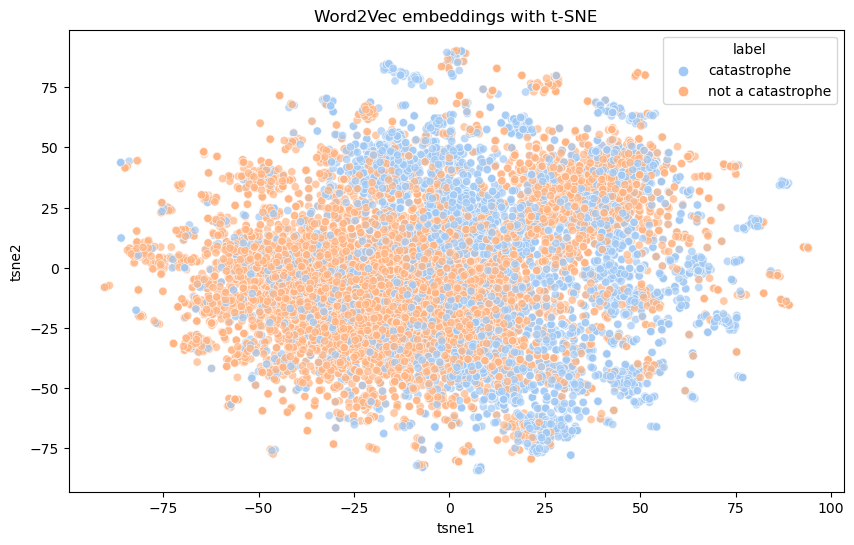

In [289]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='label', 
    palette=sns.color_palette("pastel", len(df_tsne['label'].unique())),
    data=df_tsne,
    legend="full",
    alpha=0.7
)

plt.title('Word2Vec embeddings with t-SNE')
plt.show()

**Word Similarity**

In [ ]:
keys = ['disaster', 'nuclear',  'scared', 'world', 'twitter', 'happy', 'hero', 'new', 'murder', 'quaran']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    if word in model:
        for similar_word, _ in model.most_similar(word, topn=30):
            if similar_word in model:
                words.append(similar_word)
                embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


In [ ]:
def plot(labels, embedding_clusters, word_clusters, a):
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("hsv", len(labels))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.text(x[i], y[i], word, fontsize=9)
    plt.legend(loc=4)
    plt.title('Similar words')
    plt.show()

plot(keys, embeddings_2d, word_clusters, 0.7)